In [1]:
# dependency
import numpy as np
import pandas as pd
import copy
import math
import sys
import os
from activations import relu, leaky_relu, sigmoid, tanh, softmax, d_sigmoid, d_relu
from initializers import glorot_uniform, random_normal, random_uniform
from regularizers import l1_regularizer, l2_regularizer
from utility import trim_tail, multiply, subtract, get_nparams, one_hot_encoding, get_data
from metrics import MSE, CCE, ACC, PRECISION, RECALL, essential_metrics, wondering_penalty, close_gap_penalty
from pso import PSO
from ga import GA
from nn import Network
from layer import DenseLayer
from scalers import MinMaxScaler, StandardScaler

In [2]:
# reference
metrics_fn_dict = dict()
metrics_fn_dict['accuracy'] = ACC
metrics_fn_dict['categorical_crossentropy'] = CCE
metrics_fn_dict['mean_square_error'] = MSE
metrics_fn_dict['precision'] = PRECISION
metrics_fn_dict['recall'] = RECALL
metrics_fn_dict['essential_metrics'] = essential_metrics

In [3]:
# model
model = Network(5, lr = None)
model.add_layer(DenseLayer(1, 4, True, afn=sigmoid, dafn=None, rfn=None))
model.add_layer(DenseLayer(2, 3, True, afn=softmax, dafn=None, rfn=None))

In [4]:
pso = PSO(dict(m = 50,
    weight_constraint = [-3, 3], 
    velocity_constraint = [-0.1, 0.1],
    c1 = [0.5, 2],
    c2 = [0.5, 2],
    w = [0.5, 1.6],
    w_decay = 0.95,
    scale_hyperparameter = False,
    regularizer = None,
    mask = True))

see one see two 2 0.5


In [5]:
model.compile(loss_fn = 'categorical_crossentropy', optimizer = pso, \
    metrics = ['accuracy', 'mean_square_error', 'categorical_crossentropy'])

building layer 1 with 5
24
building layer 2 with 4
15


In [6]:
# data loading
DATA = os.path.join('c:\\Users\\tcumi\\github_repo\\neural-network\\', 'dataset')
GROUP = 2
COLUMNS = ['f1', 'f2', 'f3', 'f4', 'f5', 'label']
N_CLASS = 3
EPOCHS = 500
train_dir, test_dir = "..//dataset//training_data{}.txt".format(GROUP), "..//dataset//testing_data{}.txt".format(GROUP)
train, test = get_data(DATA, train_dir, COLUMNS), get_data(DATA, test_dir, COLUMNS)
# shuffle
train, test = train.sample(frac=1), test.sample(frac=1)
x_train, y_train = train.drop('label', axis=1), train['label']
x_test, y_test = test.drop('label', axis=1), test['label']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      107 non-null    float32
 1   f2      107 non-null    float32
 2   f3      107 non-null    float32
 3   f4      107 non-null    float32
 4   f5      107 non-null    float32
 5   label   107 non-null    float32
dtypes: float32(6)
memory usage: 2.6 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   f1      108 non-null    float32
 1   f2      108 non-null    float32
 2   f3      108 non-null    float32
 3   f4      108 non-null    float32
 4   f5      108 non-null    float32
 5   label   108 non-null    float32
dtypes: float32(6)
memory usage: 2.7 KB
None


In [7]:
# data scaling and encoding
scaler = StandardScaler(['f1', 'f2', 'f3', 'f4', 'f5'])
scaler.fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
y_train = one_hot_encoding(y_train, N_CLASS)
y_test = one_hot_encoding(y_test, N_CLASS)

In [8]:
# learning phase
breakpoint = 100
checkpoints = list()
history = list()
for century in range(0, EPOCHS, breakpoint):
    sub_history = model.fit(x_train, y_train, breakpoint, verbose = 0)
    score = model.evaluate(x_test, y_test, False, verbose = 0)
    print('Checkpoint {}, Accuracy: {}, Loss: {}'.format(century+breakpoint, score['accuracy'], score[model.loss_fn]))
    score['checkpoint'] = century + breakpoint
    checkpoints.append(score)
    history.extend(sub_history)
    itr = century + breakpoint
    model.optimizer.c1 = np.max([model.optimizer.C1[1] - ((model.optimizer.C1[1] - model.optimizer.C1[0]) * itr / EPOCHS), model.optimizer.C1[0]])
    model.optimizer.c2 = np.min([model.optimizer.C2[0] + ((model.optimizer.C2[1] - model.optimizer.C2[0]) * itr / EPOCHS), model.optimizer.C2[1]])
    model.optimizer.w = np.max([model.optimizer.w * model.optimizer.W_Decay, model.optimizer.W[0]])

Checkpoint 100, Accuracy: 0.9629629629629629, Loss: 0.27804222813359014
Checkpoint 200, Accuracy: 0.9629629629629629, Loss: 0.12727815133553963
Checkpoint 300, Accuracy: 0.9629629629629629, Loss: 0.1312205261654324
Checkpoint 400, Accuracy: 0.9691358024691358, Loss: 0.12163132208364981
Checkpoint 500, Accuracy: 0.9629629629629629, Loss: 0.12657174357661494


In [9]:
import matplotlib.pyplot as plt

def draw_plot(x, y_list, x_label=None, y_label=None, legend=None, title=None):
    fig, ax = plt.subplots(figsize=(12,5))
    for xi, yi in zip(x, y_list):
        ax.plot(xi, yi)
    if x_label is not None and y_label is not None:
        ax.set(xlabel=x_label, ylabel=y_label, title='{} VS {}'.format(x_label, y_label))
    if legend is not None:
        ax.legend(legend)
    ax.grid()
    plt.show()

In [10]:
# recall phase
score = model.evaluate(x_test, y_test, False)
print(score)

[1. 0. 0.] <-> [0.9949038  0.0040796  0.00101649]
[1. 0. 0.] <-> [0.9946497  0.0012604  0.00408994]
[0. 1. 0.] <-> [1.1460498e-01 8.8519245e-01 2.0252094e-04]
[1. 0. 0.] <-> [9.6504742e-01 7.9816044e-04 3.4154382e-02]
[1. 0. 0.] <-> [0.99510455 0.00308934 0.00180604]
[1. 0. 0.] <-> [0.8523545  0.00097533 0.14667018]
[1. 0. 0.] <-> [9.9489272e-01 4.1814027e-03 9.2590635e-04]
[1. 0. 0.] <-> [0.996268   0.00202289 0.00170918]
[1. 0. 0.] <-> [9.9677354e-01 8.1807008e-04 2.4083531e-03]
[1. 0. 0.] <-> [0.95855004 0.00110679 0.04034318]
[1. 0. 0.] <-> [9.7696733e-01 2.2157403e-02 8.7524392e-04]
[1. 0. 0.] <-> [0.9964624  0.00143448 0.00210313]
[1. 0. 0.] <-> [0.9859367  0.01186104 0.00220218]
[0. 0. 1.] <-> [1.0163742e-02 2.3429424e-05 9.8981279e-01]
[1. 0. 0.] <-> [0.99181163 0.00117435 0.00701409]
[1. 0. 0.] <-> [9.8618162e-01 1.2858412e-02 9.5989724e-04]
[1. 0. 0.] <-> [9.927683e-01 7.661498e-04 6.465542e-03]
[1. 0. 0.] <-> [0.77697366 0.00105188 0.22197443]
[1. 0. 0.] <-> [9.9747878e-01 6

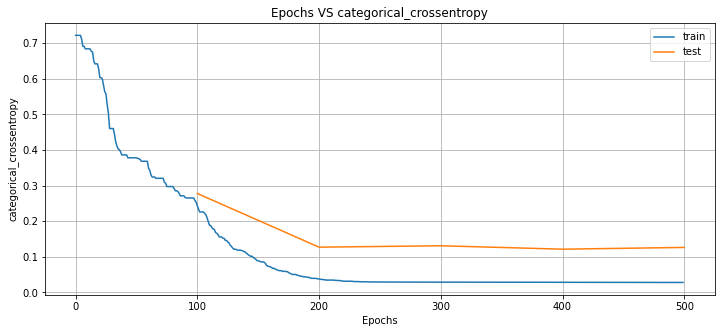

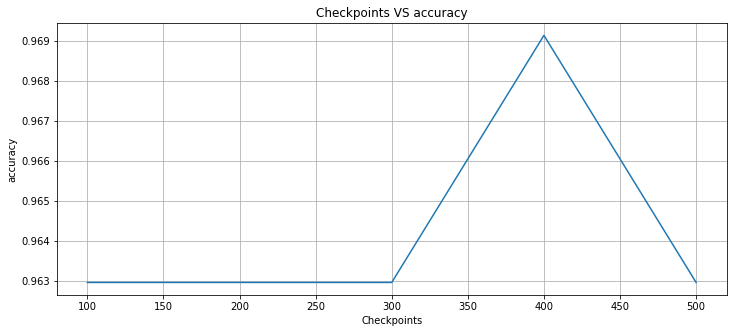

In [11]:
draw_plot(x = [[i for i in range(len(history))], [(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [history, [ ckp[model.loss_fn] for ckp in checkpoints ]], x_label = 'Epochs', \
    y_label = model.loss_fn, legend=['train', 'test'])
acc = [ ckp['accuracy'] for ckp in checkpoints ]
draw_plot(x = [[(i+1)*breakpoint for i in range(len(checkpoints))]], y_list = [acc], x_label = 'Checkpoints', \
    y_label = 'accuracy')

In [12]:
for checkpoint in checkpoints:
    print(checkpoint, '\n\n')

{'accuracy': 0.9629629629629629, 'mean_square_error': 0.12136381871231681, 'categorical_crossentropy': 0.27804222813359014, 'essential_metrics': {0: {'tp_hit': 78, 'fp_hit': 4, 'tn_hit': 24, 'fn_hit': 2}, 1: {'tp_hit': 13, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 2}, 2: {'tp_hit': 11, 'fp_hit': 1, 'tn_hit': 94, 'fn_hit': 2}}, 'checkpoint': 100} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.07252060978890186, 'categorical_crossentropy': 0.12727815133553963, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 2, 'tn_hit': 26, 'fn_hit': 4}, 1: {'tp_hit': 14, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 1}, 2: {'tp_hit': 12, 'fp_hit': 3, 'tn_hit': 92, 'fn_hit': 1}}, 'checkpoint': 200} 


{'accuracy': 0.9629629629629629, 'mean_square_error': 0.07649945166739533, 'categorical_crossentropy': 0.1312205261654324, 'essential_metrics': {0: {'tp_hit': 76, 'fp_hit': 2, 'tn_hit': 26, 'fn_hit': 4}, 1: {'tp_hit': 14, 'fp_hit': 1, 'tn_hit': 92, 'fn_hit': 1}, 2: {'tp_hit': 12, 'fp_hit': 3, 'tn_hit': 92, 

In [13]:
print(model)

Layer 1
Neuron 0: weights:
[ 1.3683472 -2.47489   -1.0497452  3.         3.       ]
 bias: 3.0

Neuron 1: weights:
[ 0.01242831 -3.          3.          2.1213474   3.        ]
 bias: -1.099374532699585

Neuron 2: weights:
[ 0.24066025  3.          1.9245418  -1.3562669  -3.        ]
 bias: 3.0

Neuron 3: weights:
[ 2.0323644 -3.        -2.2921057 -0.8506654  2.3317304]
 bias: 3.0

$
Layer 2
Neuron 0: weights:
[ 3. -3.  3.  3.]
 bias: -3.0

Neuron 1: weights:
[-3.        -1.8973447  2.6546416 -3.       ]
 bias: 1.8626185655593872

Neuron 2: weights:
[ 3.        3.       -3.        1.827071]
 bias: -3.0

$

